<a href="https://colab.research.google.com/github/dntwaritag/WeatherWise-Classifier-MLOP/blob/main/WeatherWise_Classifier(Metrix_AI)_MLOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Pipeline for Weather Classification**

This notebook implements a Machine Learning Pipeline for weather classification using the Seattle weather dataset.
It addresses the requirements of the ALU Machine Learning Pipeline Summative Assignment.

**0. Setup and Imports**

In [1]:
# 0. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import joblib
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV  # Import RandomizedSearchCV

In [2]:
# Directory for saving visualizations
VISUALIZATION_DIR = 'visualizations'
os.makedirs(VISUALIZATION_DIR, exist_ok=True)
# Directory for saving models
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
# Directory for saving data
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

**1. Data Loading and Preprocessing (Pipeline Stage 1)**

In [3]:
def load_data(path):
    """
    Loads the dataset from the given path and performs initial sorting.

    Args:
        path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded and sorted DataFrame.
    """
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    return df

In [4]:
def explore_data(df):
    """
    Displays the head, tail, and info of the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to explore.
    """
    print("--- Head ---")
    print(df.head())
    print("\n--- Tail ---")
    print(df.tail())
    print("\n--- Info ---")
    df.info()

In [5]:
def preprocess_data(df, save_encoder=True):
    """
    Preprocesses the DataFrame by dropping 'date', encoding 'weather',
    adding lag features, and handling missing values.

    Args:
        df (pd.DataFrame): DataFrame to preprocess.
        save_encoder (bool, optional): Whether to save the LabelEncoder. Defaults to True.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    df = df.drop('date', axis=1)

    # Encode 'weather' (target variable for classification)
    label_encoder = LabelEncoder()
    df['weather_encoded'] = label_encoder.fit_transform(df['weather'])
    if save_encoder:
        joblib.dump(label_encoder, os.path.join(MODEL_DIR, 'label_encoder.pkl'))  # Save encoder

    # Add lag features (for potential improvement, but be mindful of their interpretation in classification)
    df['lag_wind_1'] = df['wind'].shift(1)
    df['lag_precipitation_1'] = df['precipitation'].shift(1)
    df['lag_temp_max_1'] = df['temp_max'].shift(1)
    df['lag_temp_min_1'] = df['temp_min']

    df.dropna(inplace=True)  # Handle NaNs
    return df

In [6]:
# --- Execute Data Loading and Preprocessing ---
PATH = '/content/seattle-weather.csv'
df = load_data(PATH)
explore_data(df)
df = preprocess_data(df)

--- Head ---
        date  precipitation  temp_max  temp_min  wind  weather
0 2012-01-01            0.0      12.8       5.0   4.7  drizzle
1 2012-01-02           10.9      10.6       2.8   4.5     rain
2 2012-01-03            0.8      11.7       7.2   2.3     rain
3 2012-01-04           20.3      12.2       5.6   4.7     rain
4 2012-01-05            1.3       8.9       2.8   6.1     rain

--- Tail ---
           date  precipitation  temp_max  temp_min  wind weather
1456 2015-12-27            8.6       4.4       1.7   2.9    rain
1457 2015-12-28            1.5       5.0       1.7   1.3    rain
1458 2015-12-29            0.0       7.2       0.6   2.6     fog
1459 2015-12-30            0.0       5.6      -1.0   3.4     sun
1460 2015-12-31            0.0       5.6      -2.1   3.5     sun

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------

**2. Data Visualization**

In [7]:
def visualize_correlation(df, save=False):
    """
    Plots the correlation heatmap for numerical features.

    Args:
        df (pd.DataFrame): DataFrame to visualize.
        save (bool, optional): Whether to save the plot. Defaults to False.
    """
    plt.figure(figsize=(12, 6))
    numerical_df = df.select_dtypes(include=np.number)
    sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    if save:
        plt.savefig(os.path.join(VISUALIZATION_DIR, 'correlation_heatmap.png'))
    plt.show()

In [8]:
def visualize_distributions(df, save=False):
    """
    Plots histograms of all features.

    Args:
        df (pd.DataFrame): DataFrame to visualize.
        save (bool, optional): Whether to save the plot. Defaults to False.
    """
    df.hist(figsize=(12, 8), bins=10, edgecolor='black')
    plt.suptitle('Feature Distributions', fontsize=14)
    if save:
        plt.savefig(os.path.join(VISUALIZATION_DIR, 'feature_distributions.png'))
    plt.show()

In [9]:
def visualize_target_distribution(df, target_column, save=False):
    """
    Plots the distribution of the target variable.

    Args:
        df (pd.DataFrame): DataFrame to visualize.
        target_column (str): Name of the target column.
        save (bool, optional): Whether to save the plot. Defaults to False.
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=df)  # Use countplot for categorical
    plt.xlabel(target_column.capitalize())
    plt.ylabel('Count')
    plt.title(f'Distribution of {target_column.capitalize()}')
    if save:
        plt.savefig(os.path.join(VISUALIZATION_DIR, f'{target_column}_distribution.png'))
    plt.show()

In [10]:
def visualize_feature_relationships(df, target_column, feature_columns, save=False):
    """
    Plots boxplots to show relationships between numerical features and the categorical target.

    Args:
        df (pd.DataFrame): DataFrame to visualize.
        target_column (str): Name of the target column (categorical).
        feature_columns (list): List of feature column names (numerical).
        save (bool, optional): Whether to save the plots. Defaults to False.
    """
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(feature_columns):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x=df[target_column], y=df[feature])  # Boxplot for categorical target
        plt.xlabel(target_column.capitalize())
        plt.ylabel(feature.replace('_', ' ').title())
        plt.title(f'{feature.replace("_", " ").title()} vs {target_column.capitalize()}')
        if save:
            plt.savefig(os.path.join(VISUALIZATION_DIR, f'{feature}_vs_{target_column}.png'))
    plt.show()

In [11]:
def visualize_lag_features(df, lag_features, save=False):
    """
    Plots the distribution of lag features.

    Args:
        df (pd.DataFrame): DataFrame containing lag features.
        lag_features (list): List of lag feature column names.
        save (bool, optional): Whether to save the plots. Defaults to False.
    """
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(lag_features):
        plt.subplot(2, 2, i + 1)
        sns.histplot(df[feature], kde=True)
        plt.xlabel(feature.replace('_', ' ').title())
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature.replace("_", " ").title()}')
        if save:
            plt.savefig(os.path.join(VISUALIZATION_DIR, f'{feature}_distribution.png'))
    plt.show()

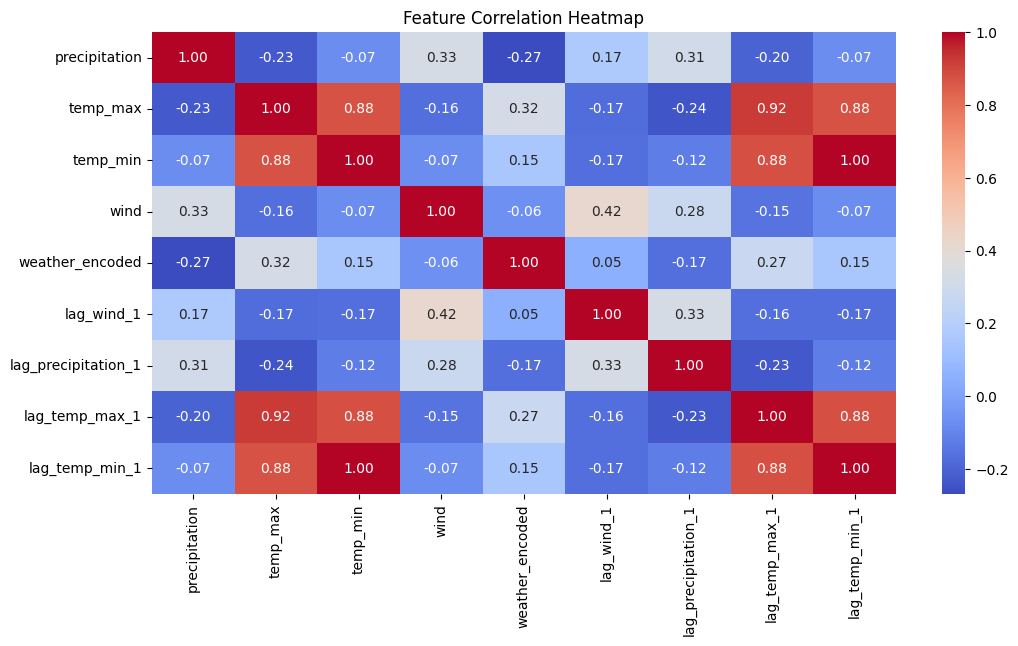

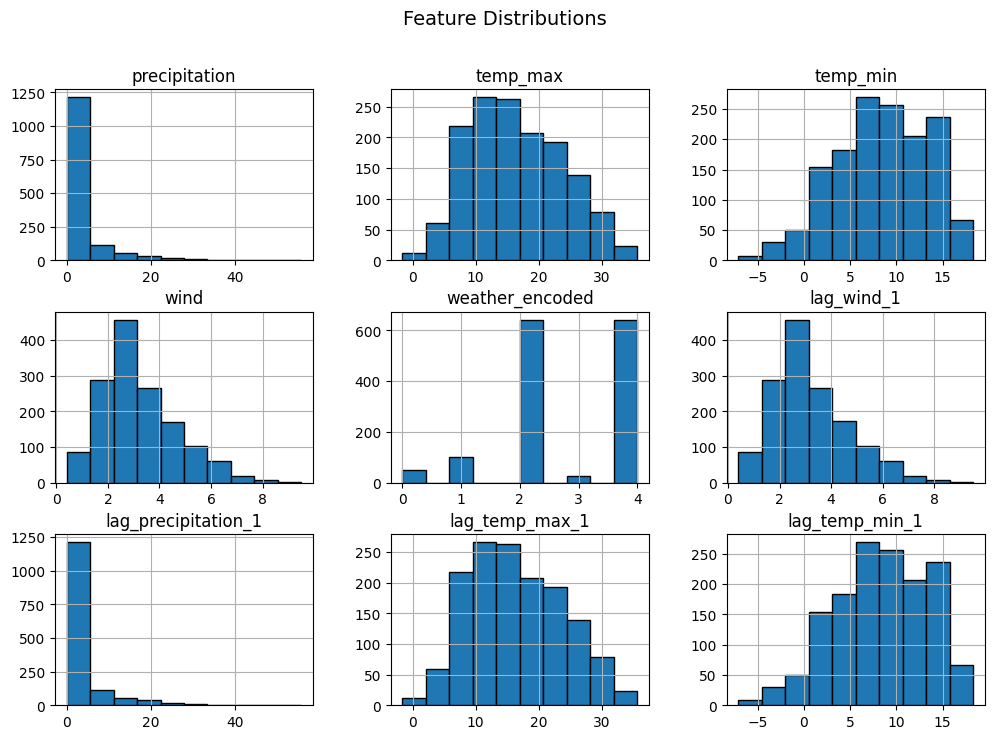

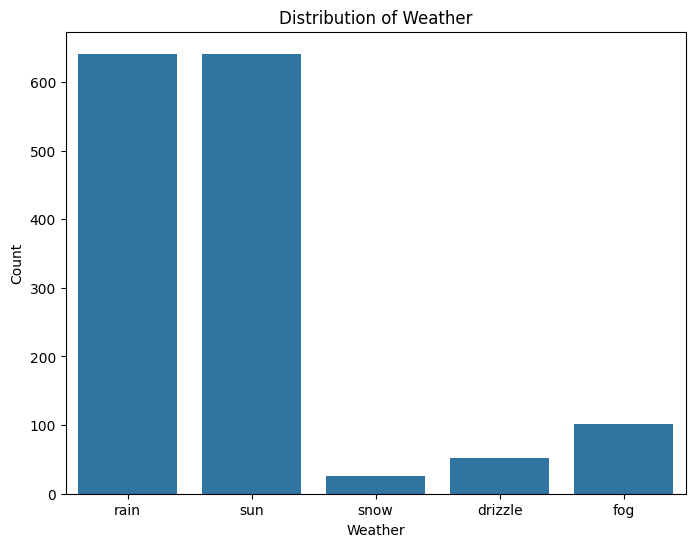

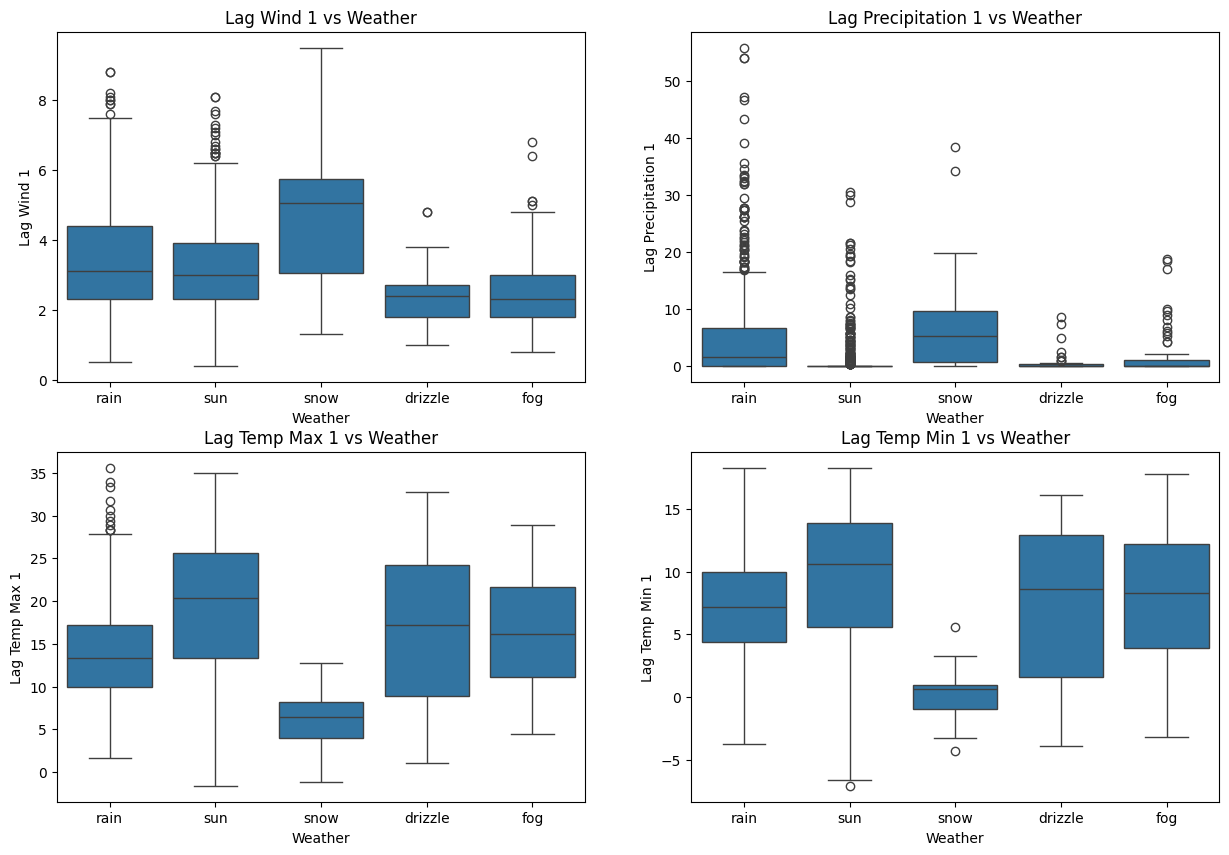

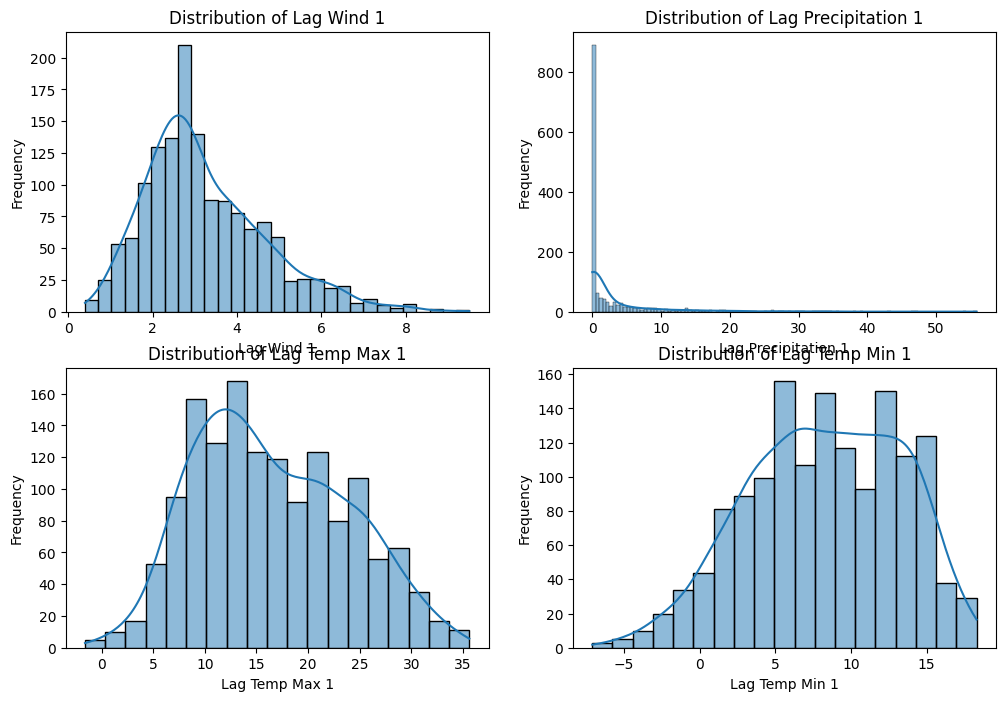

In [12]:
# --- Execute Data Visualization ---
visualize_correlation(df, save=True)
visualize_distributions(df, save=True)
visualize_target_distribution(df, 'weather', save=True)  # Visualize the categorical target
feature_cols = ['lag_wind_1', 'lag_precipitation_1', 'lag_temp_max_1', 'lag_temp_min_1']
visualize_feature_relationships(df, 'weather', feature_cols, save=True)
lag_cols = ['lag_wind_1', 'lag_precipitation_1', 'lag_temp_max_1', 'lag_temp_min_1']
visualize_lag_features(df, lag_cols, save=True)

**3. Data Splitting and Saving (Pipeline Stage 2)**

In [13]:
def split_data(df, test_size=0.3, random_state=42):
    """
    Splits the DataFrame into training and testing sets.

    Args:
        df (pd.DataFrame): DataFrame to split.
        test_size (float, optional): Proportion of the test set. Defaults to 0.3.
        random_state (int, optional): Random state for reproducibility. Defaults to 42.

    Returns:
        tuple: (train_df, test_df) - Training and testing DataFrames.
    """
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state,
                                         stratify=df['weather_encoded'])  # Stratify for classification
    return train_df, test_df

In [14]:
def save_data(train_df, test_df, output_dir='data'):
    """
    Saves the training and testing DataFrames to CSV files.

    Args:
        train_df (pd.DataFrame): Training DataFrame.
        test_df (pd.DataFrame): Testing DataFrame.
        output_dir (str, optional): Directory to save the files. Defaults to 'data'.
    """
    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
    test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)
    print(f'Datasets saved successfully in the "{output_dir}" directory!')

In [15]:
# --- Execute Data Splitting and Saving ---
train_df, test_df = split_data(df)
save_data(train_df, test_df)

Datasets saved successfully in the "data" directory!


**4. Model Training and Evaluation (Pipeline Stage 3)**

In [16]:
def load_train_test_data(train_path='data/train.csv', test_path='data/test.csv'):
    """
    Loads training and testing data from CSV files.

    Args:
        train_path (str, optional): Path to the training CSV. Defaults to 'data/train.csv'.
        test_path (str, optional): Path to the testing CSV. Defaults to 'data/test.csv'.

    Returns:
        tuple: (X_train, y_train, X_test, y_test) - Feature and target DataFrames.
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    X_train, y_train = train_df.drop(['weather', 'weather_encoded'], axis=1), train_df[
        'weather_encoded']  # Drop both original and encoded
    X_test, y_test = test_df.drop(['weather', 'weather_encoded'], axis=1), test_df['weather_encoded']
    return X_train, y_train, X_test, y_test

In [17]:
def preprocess_model_data(X_train, X_test):
    """
    Handles missing values and scales the data.

    Args:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.

    Returns:
        tuple: (X_train_processed, X_test_processed) - Processed feature DataFrames.
    """
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    return X_train_scaled, X_test_scaled

In [18]:
def evaluate_classification_model(model, X_test, y_test, model_name, save=False):
    """
    Evaluates a classification model and prints performance metrics.

    Args:
        model: Trained classification model.
        X_test (np.ndarray): Testing features.
        y_test (pd.Series): True labels for the test set.
        model_name (str): Name of the model.
        save (bool, optional): Whether to save the confusion matrix plot. Defaults to False.

    Returns:
        dict: Dictionary of evaluation metrics.
    """
    # Get predicted labels (convert probabilities to class labels if necessary)
    y_pred_proba = model.predict(X_test)  # Get predicted probabilities
    if isinstance(model, tf.keras.models.Sequential):  # Check if it's a Keras Sequential model
        y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels
    else:
        y_pred = model.predict(X_test)  # For other models, use predict directly

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'classification_report': classification_report(y_test, y_pred, zero_division=0)
    }

    print(f'\n--- {model_name} Metrics ---')
    for metric, value in metrics.items():
        if metric != 'classification_report':
            print(f'{metric.capitalize()}: {value:.4f}')
        else:
            print(f'\nClassification Report:\n{value}')

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} Confusion Matrix')
    if save:
        plt.savefig(os.path.join(VISUALIZATION_DIR, f'{model_name}_confusion_matrix.png'))
    plt.show()

    # ROC AUC (if binary or multiclass ovo)
    if len(np.unique(y_test)) > 2:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
            print(f'ROC AUC (OVO): {roc_auc:.4f}')
            metrics['roc_auc'] = roc_auc
        except ValueError as e:
            print(f"ROC AUC not calculated: {e}")
    else:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend()
        if save:
            plt.savefig(os.path.join(VISUALIZATION_DIR, f'{model_name}_roc_curve.png'))
        plt.show()
        metrics['roc_auc'] = roc_auc

    return metrics

In [19]:
def train_and_evaluate_logreg(X_train, y_train, X_test, y_test, save=False):
    """
    Trains and evaluates a Logistic Regression model with hyperparameter tuning.

    Args:
        X_train (np.ndarray): Training features.
        y_train (pd.Series): Training labels.
        X_test (np.ndarray): Testing features.
        y_test (pd.Series): Testing labels.
        save (bool, optional): Whether to save the model. Defaults to False.

    Returns:
        LogisticRegression: Trained model.
        dict: Evaluation metrics.
    """
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Add 'saga'
        'penalty': ['l1', 'l2'],  # Remove 'elasticnet' and keep 'l1', 'l2'
        'max_iter': [100, 200, 300]
    }
    # Adjust the param_grid for solver-penalty compatibility:
    # For 'lbfgs' solver, only use 'l2' penalty.
    # For 'liblinear' and 'saga' solvers, use 'l1' and 'l2' penalties.

    param_grid = [
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2'], 'max_iter': [100, 200, 300]},
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'max_iter': [100, 200, 300]}
    ]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=cv, scoring='accuracy', verbose=0,
                                   error_score='raise')  # Set error_score to 'raise'
    grid_search.fit(X_train, y_train)

    best_logreg_model = grid_search.best_estimator_
    print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")

    metrics = evaluate_classification_model(best_logreg_model, X_test, y_test, 'Logistic Regression', save=save)
    if save:
        joblib.dump(best_logreg_model, os.path.join(MODEL_DIR, 'logistic_regression_model.pkl'))
    return best_logreg_model, metrics

In [20]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, save=False):

    # Reduced param_grid
    param_grid = {
        'n_estimators': [50, 150, 300],  # Coarser grid
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    }

    # Using RandomizedSearchCV with a smaller number of iterations
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                       param_distributions=param_grid,
                                       n_iter=10,  # Number of random iterations
                                       cv=cv, scoring='accuracy', verbose=0,
                                       error_score='raise')
    random_search.fit(X_train, y_train)

    best_rf_model = random_search.best_estimator_
    print(f"Best Random Forest Parameters: {random_search.best_params_}") # Changed grid_search to random_search

    metrics = evaluate_classification_model(best_rf_model, X_test, y_test, 'Random Forest', save=save)
    if save:
        joblib.dump(best_rf_model, os.path.join(MODEL_DIR, 'random_forest_model.pkl'))
    return best_rf_model, metrics

In [21]:
# def train_and_evaluate_nn(X_train, y_train, X_test, y_test, save=False, epochs=100, batch_size=32, learning_rate=0.001,
#                           patience=10):
#     """
#     Trains and evaluates a Neural Network model.

#     Args:
#         X_train (np.ndarray): Training features.
#         y_train (pd.Series): Training labels.
#         X_test (np.ndarray): Testing features.
#         y_test (pd.Series): Testing labels.
#         save (bool, optional): Whether to save the model. Defaults to False.
#         epochs (int, optional): Number of epochs. Defaults to 100.
#         batch_size (int, optional): Batch size. Defaults to 32.
#         learning_rate (float, optional): Learning rate. Defaults to 0.001.
#         patience (int, optional): Patience for early stopping. Defaults to 10.

#     Returns:
#         tf.keras.models.Sequential: Trained model.
#         dict: Evaluation metrics.
#     """

#     # Model Architecture
#     nn_model = Sequential([
#         Dense(256, activation='relu', input_shape=(X_train.shape[0],), kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(128, activation='relu', kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
#     ])

#     nn_model.compile(optimizer=Adam(learning_rate=learning_rate),
#                      loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
#                      metrics=['accuracy'])

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)

#     # Train the model
#     history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size,
#                            callbacks=[early_stopping], verbose=0)

#     # Evaluate the model
#     metrics = evaluate_classification_model(nn_model, X_test, y_test, 'Neural Network', save=save)

#     # Save the model
#     if save:
#         nn_model.save(os.path.join(MODEL_DIR, 'neural_network_model.h5'))

#     return nn_model, metrics, history

In [22]:
def train_and_evaluate_nn(X_train, y_train, X_test, y_test, save=False, epochs=100, batch_size=32, learning_rate=0.001,
                          patience=10):
    """
    Trains and evaluates a Neural Network model.

    Args:
        X_train (np.ndarray): Training features.
        y_train (pd.Series): Training labels.
        X_test (np.ndarray): Testing features.
        y_test (pd.Series): Testing labels.
        save (bool, optional): Whether to save the model. Defaults to False.
        epochs (int, optional): Number of epochs. Defaults to 100.
        batch_size (int, optional): Batch size. Defaults to 32.
        learning_rate (float, optional): Learning rate. Defaults to 0.001.
        patience (int, optional): Patience for early stopping. Defaults to 10.

    Returns:
        tf.keras.models.Sequential: Trained model.
        dict: Evaluation metrics.
    """

    # Model Architecture
    nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='he_normal'),  # Change input_shape
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
    ])

    nn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
                     metrics=['accuracy'])

    # Early Stopping (Optional - you can comment this out to train for fixed epochs)
    # early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)

    # Train the model
    history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size,
                           # callbacks=[early_stopping],  # Comment out to train for fixed epochs
                           verbose=1)  # Set verbose to 1 to see training progress

    # Evaluate the model
    metrics = evaluate_classification_model(nn_model, X_test, y_test, 'Neural Network', save=save)

    # Save the model
    if save:
        nn_model.save(os.path.join(MODEL_DIR, 'neural_network_model.h5'))

    return nn_model, metrics, history

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Logistic Regression Parameters: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

--- Logistic Regression Metrics ---
Accuracy: 0.8265
Precision_macro: 0.4414
Recall_macro: 0.4010
F1_macro: 0.3954

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        30
           2       0.96      0.90      0.93       192
           3       0.50      0.12      0.20         8
           4       0.75      0.98      0.85       192

    accuracy                           0.83       438
   macro avg       0.44      0.40      0.40       438
weighted avg       0.76      0.83      0.78       438



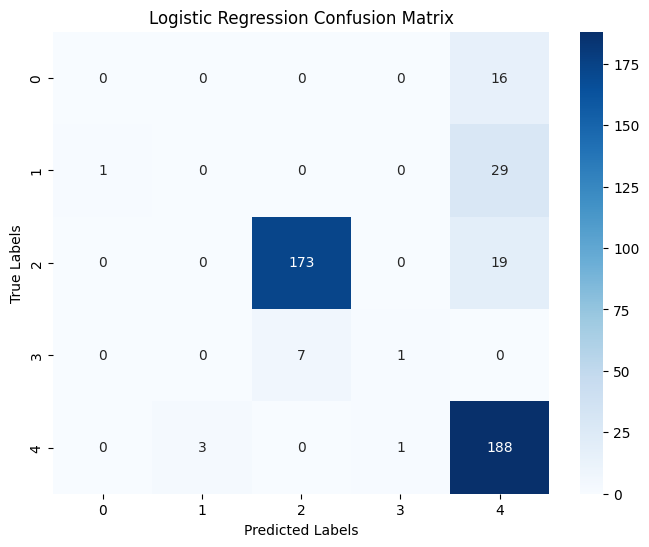

ROC AUC not calculated: axis 1 is out of bounds for array of dimension 1


In [23]:
# --- Execute Model Training and Evaluation ---
X_train, y_train, X_test, y_test = load_train_test_data()
X_train_scaled, X_test_scaled = preprocess_model_data(X_train, X_test)

logreg_model, logreg_metrics = train_and_evaluate_logreg(X_train_scaled, y_train, X_test_scaled, y_test, save=True)


Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}

--- Random Forest Metrics ---
Accuracy: 0.8356
Precision_macro: 0.5843
Recall_macro: 0.4587
F1_macro: 0.4781

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.20      0.03      0.06        30
           2       0.97      0.91      0.94       192
           3       1.00      0.38      0.55         8
           4       0.76      0.98      0.85       192

    accuracy                           0.84       438
   macro avg       0.58      0.46      0.48       438
weighted avg       0.79      0.84      0.80       438



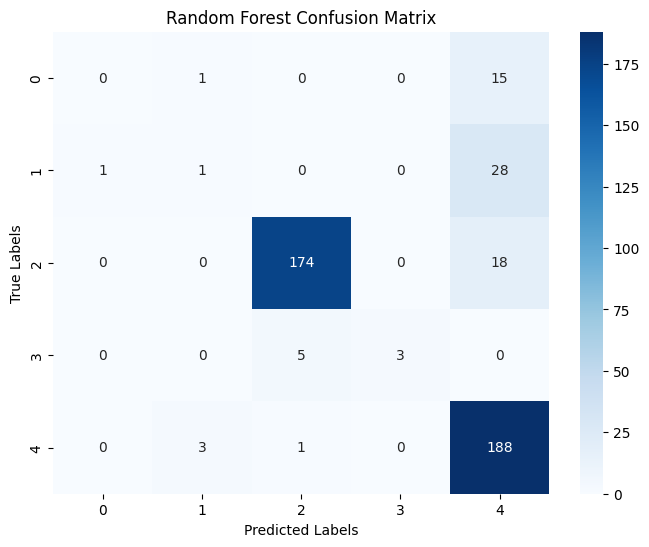

ROC AUC not calculated: axis 1 is out of bounds for array of dimension 1


In [24]:
rf_model, rf_metrics = train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test, save=True)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3570 - loss: 1.9397 - val_accuracy: 0.6073 - val_loss: 1.2707
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6382 - loss: 1.1899 - val_accuracy: 0.6484 - val_loss: 1.1490
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6529 - loss: 1.1130 - val_accuracy: 0.7123 - val_loss: 0.9704
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6720 - loss: 1.0340 - val_accuracy: 0.7215 - val_loss: 0.9006
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7366 - loss: 0.8795 - val_accuracy: 0.7260 - val_loss: 0.8439
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6885 - loss: 0.8913 - val_accuracy: 0.7237 - val_loss: 0.8136
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7399 - loss: 0.8785 - val_accuracy: 0.7352 - val_loss: 0.7735
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7238 - loss: 0.8901 - val_accuracy: 0.7260 - val_loss

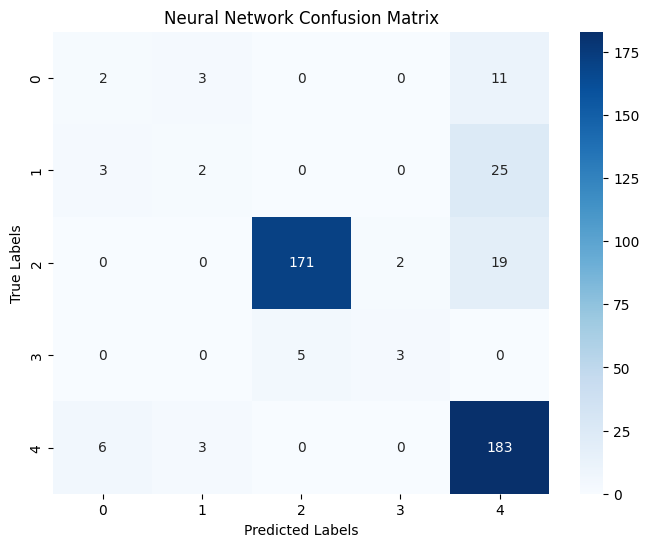

ROC AUC (OVO): 0.8672


In [25]:
nn_model, nn_metrics, nn_history = train_and_evaluate_nn(X_train_scaled, y_train, X_test_scaled, y_test, save=True)

**5. Additional Visualizations**

In [26]:
def visualize_training_history(history, save=False):
    """
    Visualizes the training history of a neural network (loss and accuracy).

    Args:
        history: The training history object returned by model.fit().
        save (bool, optional): Whether to save the plots. Defaults to False.
    """
    # Check if history is provided
    if history is not None and isinstance(history, dict):  # Check if history is a dictionary
        plt.figure(figsize=(12, 5))

        # Plot loss (if 'loss' key is present)
        if 'loss' in history:
            plt.subplot(1, 2, 1)
            plt.plot(history['loss'], label='Train Loss')
            plt.plot(history.get('val_loss', []), label='Validation Loss')  # Handle missing 'val_loss'
            plt.title('Training Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            if save:
                plt.savefig(os.path.join(VISUALIZATION_DIR, 'nn_training_loss.png'))

        # Plot accuracy (if 'accuracy' key is present)
        if 'accuracy' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['accuracy'], label='Train Accuracy')
            plt.plot(history.get('val_accuracy', []), label='Validation Accuracy')  # Handle missing 'val_accuracy'
            plt.title('Training Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            if save:
                plt.savefig(os.path.join(VISUALIZATION_DIR, 'nn_training_accuracy.png'))

        plt.show()
    else:
        print("No training history provided or history is not in the expected format.")
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        if save:
            plt.savefig(os.path.join(VISUALIZATION_DIR, 'nn_training_accuracy.png'))

        plt.show()

No training history provided or history is not in the expected format.


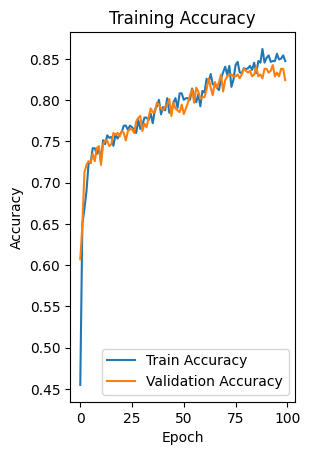

In [27]:
# --- Execute Additional Visualizations ---
visualize_training_history(nn_history, save=True)

**6. Data and Visualization Zipping**

In [28]:
def zip_directory(directory, archive_name):
    """
    Zips the specified directory.

    Args:
        directory (str): Path to the directory to zip.
        archive_name (str): Name of the archive (without extension).
    """
    shutil.make_archive(archive_name, 'zip', directory)
    print(f"'{directory}' directory zipped successfully as '{archive_name}.zip'!")


# --- Execute Data and Visualization Zipping ---
zip_directory(DATA_DIR, 'data')
zip_directory(VISUALIZATION_DIR, 'visualizations')

print("All data, models, and visualizations saved and zipped successfully!")

'data' directory zipped successfully as 'data.zip'!
'visualizations' directory zipped successfully as 'visualizations.zip'!
All data, models, and visualizations saved and zipped successfully!
